In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To do:

try small mu

for loop (convolve one basis at a time)

stop at every location (bandwidths, bubbles, smoothed basis, etc.) check after one iteration if the memory usage increase

In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

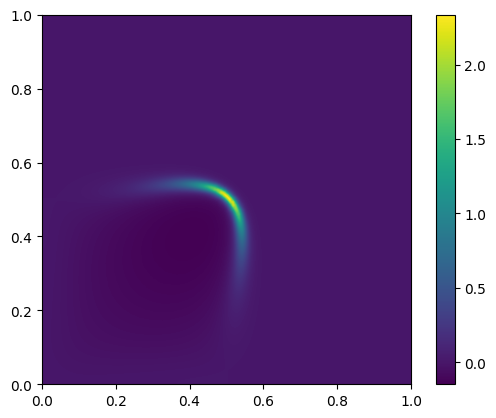

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [8]:
m = 500
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

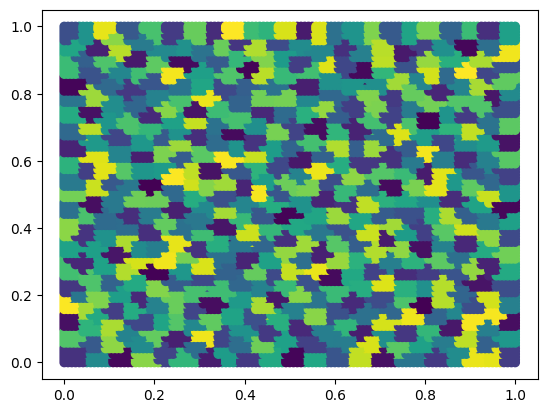

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

w: n x N

In [10]:
# # distance: N x mu
# # w: n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).expand(n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # n x N x mu
#     return window

In [11]:
# # x: n x N
# # neighbour_id: N x mu
# # w: n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     # n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id] * bubbles, dim=-1)

w: b x n x N

In [12]:
# # distance: N x mu
# # w: b x n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[1]
#     b = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).unsqueeze(0).expand(b, n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # b x n x N x mu
#     return window

In [13]:
# # x(decoder): n x N
# # neighbour_id: N x mu
# # w: b x n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     b = w.shape[0]
#     # b x n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id].unsqueeze(0).expand(b,-1,-1,-1) * bubbles, dim=-1)


In [14]:
N = datas.shape[1] // 2
n = 30
# fixed support (length)
mu = int(np.ceil(N/200))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [15]:
batch_size = 8
datas = datas.to(device)
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [16]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [17]:
# ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [18]:
# torch.autograd.set_detect_anomaly(True)
ed.train(train_data_loader=train_data, epochs=1000)

100%|██████████| 125/125 [00:14<00:00,  8.64it/s]


Itr 0, loss = 996.5863463454675


100%|██████████| 125/125 [00:14<00:00,  8.71it/s]


Itr 1, loss = 994.3623037117103


100%|██████████| 125/125 [00:14<00:00,  8.71it/s]


Itr 2, loss = 989.6535296360295


100%|██████████| 125/125 [00:14<00:00,  8.81it/s]


Itr 3, loss = 982.1348591475098


100%|██████████| 125/125 [00:14<00:00,  8.59it/s]


Itr 4, loss = 971.9149467536615


100%|██████████| 125/125 [00:14<00:00,  8.53it/s]


Itr 5, loss = 958.8315998608533


100%|██████████| 125/125 [00:14<00:00,  8.44it/s]


Itr 6, loss = 942.1439675842211


100%|██████████| 125/125 [00:15<00:00,  8.29it/s]


Itr 7, loss = 921.3943967920083


100%|██████████| 125/125 [00:15<00:00,  8.12it/s]


Itr 8, loss = 898.0125785803966


100%|██████████| 125/125 [00:15<00:00,  7.98it/s]


Itr 9, loss = 875.7529934215772


100%|██████████| 125/125 [00:15<00:00,  7.87it/s]


Itr 10, loss = 857.5190091273743


100%|██████████| 125/125 [00:16<00:00,  7.80it/s]


Itr 11, loss = 844.0854019821445


100%|██████████| 125/125 [00:16<00:00,  7.76it/s]


Itr 12, loss = 833.8754478504276


100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Itr 13, loss = 825.364342835336


100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Itr 14, loss = 817.6773013115392


100%|██████████| 125/125 [00:16<00:00,  7.73it/s]


Itr 15, loss = 810.690003404641


100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Itr 16, loss = 803.1626059489073


100%|██████████| 125/125 [00:16<00:00,  7.71it/s]


Itr 17, loss = 794.6598106922705


100%|██████████| 125/125 [00:16<00:00,  7.71it/s]


Itr 18, loss = 786.0078375425518


100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


Itr 19, loss = 776.6927202232885


100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


Itr 20, loss = 767.202817525166


100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


Itr 21, loss = 757.446121373496


100%|██████████| 125/125 [00:14<00:00,  8.58it/s]


Itr 22, loss = 746.3017848655857


100%|██████████| 125/125 [00:14<00:00,  8.70it/s]


Itr 23, loss = 733.9566683401271


100%|██████████| 125/125 [00:16<00:00,  7.66it/s]


Itr 24, loss = 721.6781688945148


100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Itr 25, loss = 708.739175742139


100%|██████████| 125/125 [00:16<00:00,  7.63it/s]


Itr 26, loss = 695.4358976847806


100%|██████████| 125/125 [00:16<00:00,  7.62it/s]


Itr 27, loss = 682.47520113648


100%|██████████| 125/125 [00:16<00:00,  7.63it/s]


Itr 28, loss = 668.7659106861988


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 29, loss = 654.5616485281457


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 30, loss = 641.1781102595224


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 31, loss = 627.7018229480101


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 32, loss = 615.1038149616046


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 33, loss = 602.6523130399299


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 34, loss = 590.3884657043328


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 35, loss = 577.281117358341


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 36, loss = 564.7458390682398


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 37, loss = 552.8317754529432


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 38, loss = 541.7437922744335


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 39, loss = 531.6954105134774


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 40, loss = 521.8534727506338


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 41, loss = 512.806506485864


100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Itr 42, loss = 503.4614827859958


100%|██████████| 125/125 [00:14<00:00,  8.70it/s]


Itr 43, loss = 494.24370971700586


100%|██████████| 125/125 [00:14<00:00,  8.67it/s]


Itr 44, loss = 485.5164184337096


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 45, loss = 477.45855243152937


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 46, loss = 469.5884294392134


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 47, loss = 462.0102811874792


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 48, loss = 454.65080741495575


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 49, loss = 447.6118985031137


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 50, loss = 441.0498063046138


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 51, loss = 434.5396409148325


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 52, loss = 428.1371443506094


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 53, loss = 421.9578535726455


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 54, loss = 416.0917223378149


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 55, loss = 410.46270412813294


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 56, loss = 404.66181126242367


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 57, loss = 399.27352284547527


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 58, loss = 393.79604927140934


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 59, loss = 388.4114289710619


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 60, loss = 383.3291147355441


100%|██████████| 125/125 [00:16<00:00,  7.76it/s]


Itr 61, loss = 378.3038042608892


100%|██████████| 125/125 [00:15<00:00,  8.06it/s]


Itr 62, loss = 373.3604515636934


100%|██████████| 125/125 [00:14<00:00,  8.62it/s]


Itr 63, loss = 368.3709861822567


100%|██████████| 125/125 [00:14<00:00,  8.57it/s]


Itr 64, loss = 363.61820093935864


100%|██████████| 125/125 [00:15<00:00,  8.22it/s]


Itr 65, loss = 358.90965534663445


100%|██████████| 125/125 [00:14<00:00,  8.63it/s]


Itr 66, loss = 354.2092942752666


100%|██████████| 125/125 [00:14<00:00,  8.66it/s]


Itr 67, loss = 349.84674417877005


100%|██████████| 125/125 [00:14<00:00,  8.70it/s]


Itr 68, loss = 345.14716095500125


100%|██████████| 125/125 [00:14<00:00,  8.75it/s]


Itr 69, loss = 340.6527789442525


100%|██████████| 125/125 [00:14<00:00,  8.68it/s]


Itr 70, loss = 336.3603346967175


100%|██████████| 125/125 [00:14<00:00,  8.65it/s]


Itr 71, loss = 332.1787862476768


100%|██████████| 125/125 [00:14<00:00,  8.67it/s]


Itr 72, loss = 328.04259648301394


100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Itr 73, loss = 323.8743483747835


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 74, loss = 319.79053669492157


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 75, loss = 315.5982435161555


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 76, loss = 311.7652303659654


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 77, loss = 308.03900992763727


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 78, loss = 304.2458923129472


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 79, loss = 300.51827818695796


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 80, loss = 296.85434390467674


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 81, loss = 293.2474500986124


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 82, loss = 289.6631719392665


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 83, loss = 286.29566629900575


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 84, loss = 282.8927985295978


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 85, loss = 279.5539412421474


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 86, loss = 276.19502101463536


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 87, loss = 273.04351645427306


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 88, loss = 269.8687992932561


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 89, loss = 266.74238801382285


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 90, loss = 263.8219307075479


100%|██████████| 125/125 [00:15<00:00,  8.28it/s]


Itr 91, loss = 260.79439612121905


100%|██████████| 125/125 [00:15<00:00,  8.19it/s]


Itr 92, loss = 257.991432399381


100%|██████████| 125/125 [00:15<00:00,  7.94it/s]


Itr 93, loss = 255.0297048561035


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 94, loss = 252.1599071903995


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 95, loss = 249.38916085807188


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 96, loss = 246.63471152468267


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 97, loss = 243.89085724475237


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 98, loss = 241.40132675714094


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 99, loss = 238.77362529412264


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 100, loss = 236.2296295550844


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 101, loss = 233.5911469476845


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 102, loss = 231.10353524937167


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 103, loss = 228.72057425667143


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 104, loss = 226.43305040920345


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 105, loss = 224.00848740295368


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 106, loss = 221.71936080771516


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 107, loss = 219.39797047810262


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 108, loss = 217.1489500040364


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 109, loss = 214.98755840535068


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 110, loss = 212.80116256388885


100%|██████████| 125/125 [00:15<00:00,  8.10it/s]


Itr 111, loss = 210.66804459855248


100%|██████████| 125/125 [00:15<00:00,  8.22it/s]


Itr 112, loss = 208.6186394963019


100%|██████████| 125/125 [00:14<00:00,  8.73it/s]


Itr 113, loss = 206.64966175384657


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 114, loss = 204.68559845051206


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 115, loss = 202.7830699139621


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 116, loss = 200.90378471863676


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 117, loss = 199.03834341247688


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 118, loss = 197.31785905684455


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 119, loss = 195.53158870520667


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 120, loss = 193.71936536463738


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 121, loss = 192.08272071093634


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 122, loss = 190.445203680995


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 123, loss = 188.91147721637773


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 124, loss = 187.29755683578668


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 125, loss = 185.70881645118337


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 126, loss = 184.22468246832372


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 127, loss = 182.74374785226055


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 128, loss = 181.2891936247336


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 129, loss = 179.88737019855967


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 130, loss = 178.52965054271445


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 131, loss = 177.0727137971799


100%|██████████| 125/125 [00:15<00:00,  7.97it/s]


Itr 132, loss = 175.72556431493416


100%|██████████| 125/125 [00:14<00:00,  8.45it/s]


Itr 133, loss = 174.23252071386943


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Itr 134, loss = 172.90471370636536


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 135, loss = 171.69421751617782


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 136, loss = 170.23943988186525


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 137, loss = 169.09170230057637


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 138, loss = 167.7807706107764


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 139, loss = 166.54811508574844


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 140, loss = 165.33360192234343


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 141, loss = 164.08653846448877


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 142, loss = 162.90862788027357


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 143, loss = 161.70088759559587


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 144, loss = 160.73120104772028


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 145, loss = 159.43898033028154


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 146, loss = 158.2718013215394


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 147, loss = 157.10774993177995


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 148, loss = 156.0760807417037


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 149, loss = 155.10592209322772


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 150, loss = 154.15175359542636


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 151, loss = 153.02781775631522


100%|██████████| 125/125 [00:16<00:00,  7.67it/s]


Itr 152, loss = 152.00897313196367


100%|██████████| 125/125 [00:15<00:00,  8.21it/s]


Itr 153, loss = 150.97630168010411


100%|██████████| 125/125 [00:14<00:00,  8.69it/s]


Itr 154, loss = 149.97142513779804


100%|██████████| 125/125 [00:14<00:00,  8.62it/s]


Itr 155, loss = 149.03827094243397


100%|██████████| 125/125 [00:14<00:00,  8.73it/s]


Itr 156, loss = 148.13448375883834


100%|██████████| 125/125 [00:14<00:00,  8.75it/s]


Itr 157, loss = 147.27901160337888


100%|██████████| 125/125 [00:14<00:00,  8.67it/s]


Itr 158, loss = 146.49628200594995


100%|██████████| 125/125 [00:14<00:00,  8.63it/s]


Itr 159, loss = 145.52476535613036


100%|██████████| 125/125 [00:14<00:00,  8.68it/s]


Itr 160, loss = 144.6158322239397


100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


Itr 161, loss = 143.70826056974357


100%|██████████| 125/125 [00:14<00:00,  8.70it/s]


Itr 162, loss = 142.7778912294445


100%|██████████| 125/125 [00:14<00:00,  8.65it/s]


Itr 163, loss = 141.87577876310934


100%|██████████| 125/125 [00:14<00:00,  8.64it/s]


Itr 164, loss = 141.16766054916303


100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


Itr 165, loss = 140.24348073130565


100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


Itr 166, loss = 139.40681462417334


100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


Itr 167, loss = 138.60845700679826


100%|██████████| 125/125 [00:14<00:00,  8.61it/s]


Itr 168, loss = 137.9392869634753


100%|██████████| 125/125 [00:14<00:00,  8.70it/s]


Itr 169, loss = 137.08928349996629


100%|██████████| 125/125 [00:14<00:00,  8.67it/s]


Itr 170, loss = 136.17227514053135


100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


Itr 171, loss = 135.4886270623068


100%|██████████| 125/125 [00:14<00:00,  8.74it/s]


Itr 172, loss = 134.704649837099


100%|██████████| 125/125 [00:14<00:00,  8.59it/s]


Itr 173, loss = 134.00904475011157


100%|██████████| 125/125 [00:14<00:00,  8.66it/s]


Itr 174, loss = 133.34618879705326


100%|██████████| 125/125 [00:14<00:00,  8.66it/s]


Itr 175, loss = 132.6060779882329


100%|██████████| 125/125 [00:14<00:00,  8.66it/s]


Itr 176, loss = 131.89415845729795


100%|██████████| 125/125 [00:14<00:00,  8.65it/s]


Itr 177, loss = 131.00949376084557


100%|██████████| 125/125 [00:14<00:00,  8.66it/s]


Itr 178, loss = 130.46336544271142


100%|██████████| 125/125 [00:14<00:00,  8.68it/s]


Itr 179, loss = 129.6789008023953


100%|██████████| 125/125 [00:14<00:00,  8.71it/s]


Itr 180, loss = 129.0209856346758


100%|██████████| 125/125 [00:14<00:00,  8.62it/s]


Itr 181, loss = 128.34177625981528


100%|██████████| 125/125 [00:14<00:00,  8.69it/s]


Itr 182, loss = 127.59055015825192


100%|██████████| 125/125 [00:14<00:00,  8.63it/s]


Itr 183, loss = 126.93431610158672


100%|██████████| 125/125 [00:14<00:00,  8.61it/s]


Itr 184, loss = 126.26714864145694


100%|██████████| 125/125 [00:14<00:00,  8.61it/s]


Itr 185, loss = 125.59852376862509


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 186, loss = 124.95666264390096


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 187, loss = 124.22853753209448


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 188, loss = 123.64877372538082


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 189, loss = 122.9239315751067


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 190, loss = 122.29974795414947


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 191, loss = 121.73756480479577


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 192, loss = 121.06408521691141


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 193, loss = 120.43486504105863


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 194, loss = 119.81457684503326


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 195, loss = 119.11241343277398


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 196, loss = 118.92445050059621


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 197, loss = 118.13675144963338


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 198, loss = 117.56300892281634


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 199, loss = 116.95238729399544


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 200, loss = 116.15538118943458


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 201, loss = 115.76982789771161


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 202, loss = 115.27774031846344


100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Itr 203, loss = 114.4698716545725


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Itr 204, loss = 113.98524717206537


100%|██████████| 125/125 [00:14<00:00,  8.40it/s]


Itr 205, loss = 113.36173275215914


100%|██████████| 125/125 [00:15<00:00,  8.12it/s]


Itr 206, loss = 112.79635758737028


100%|██████████| 125/125 [00:15<00:00,  8.12it/s]


Itr 207, loss = 112.17418594183437


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 208, loss = 111.85203002321725


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 209, loss = 111.3040788925629


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 210, loss = 110.61151950931767


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 211, loss = 110.1486334515782


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 212, loss = 109.64603878747523


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 213, loss = 109.01014488849516


100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


Itr 214, loss = 108.42814227802225


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 215, loss = 108.00388559969389


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 216, loss = 107.6926275983038


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 217, loss = 107.03767360653973


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 218, loss = 106.62624831841296


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 219, loss = 106.18758600598322


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 220, loss = 105.64550158119204


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 221, loss = 105.31823293860515


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 222, loss = 104.78323011839


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 223, loss = 104.24632624193039


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 224, loss = 103.97565076890993


100%|██████████| 125/125 [00:14<00:00,  8.61it/s]


Itr 225, loss = 103.33558864291523


100%|██████████| 125/125 [00:15<00:00,  8.25it/s]


Itr 226, loss = 102.88200594974906


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 227, loss = 102.40614770401343


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 228, loss = 101.94833917138133


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 229, loss = 101.59622025097012


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 230, loss = 101.2314294077886


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 231, loss = 100.67876480550811


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 232, loss = 100.32397939737533


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 233, loss = 99.92340308988761


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 234, loss = 99.53049560987876


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 235, loss = 99.16370244607538


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 236, loss = 98.63460118968929


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 237, loss = 98.35241802512063


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 238, loss = 97.78356360953202


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 239, loss = 97.40729411376776


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 240, loss = 97.09065326290991


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 241, loss = 96.49818570301628


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 242, loss = 96.31855611637205


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 243, loss = 95.82651155589512


100%|██████████| 125/125 [00:15<00:00,  8.26it/s]


Itr 244, loss = 95.28070411594148


100%|██████████| 125/125 [00:14<00:00,  8.68it/s]


Itr 245, loss = 94.88023674563084


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 246, loss = 94.56261400206387


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 247, loss = 94.09449761226388


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 248, loss = 93.77977697157165


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 249, loss = 93.46027740502706


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 250, loss = 93.16626814293114


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 251, loss = 93.02664394376615


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 252, loss = 92.66185479377384


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 253, loss = 92.30703535705429


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 254, loss = 91.96765266377402


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 255, loss = 91.61620807822511


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 256, loss = 91.03471608629727


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 257, loss = 90.40860504697932


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 258, loss = 90.19011795409838


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 259, loss = 89.87772744341628


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 260, loss = 89.41636002015619


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 261, loss = 89.16926812199229


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 262, loss = 88.85989090757174


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 263, loss = 88.60739398433171


100%|██████████| 125/125 [00:15<00:00,  8.22it/s]


Itr 264, loss = 88.18245603811165


100%|██████████| 125/125 [00:14<00:00,  8.42it/s]


Itr 265, loss = 88.23009927089726


100%|██████████| 125/125 [00:14<00:00,  8.64it/s]


Itr 266, loss = 87.6360625514105


100%|██████████| 125/125 [00:14<00:00,  8.72it/s]


Itr 267, loss = 87.15290481011807


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 268, loss = 86.73818390811857


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 269, loss = 86.61161044854056


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 270, loss = 86.26412788989505


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 271, loss = 86.07057396452106


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 272, loss = 85.80207654171136


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 273, loss = 85.42905919450709


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 274, loss = 85.24406041555595


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 275, loss = 84.80855956861726


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 276, loss = 84.55497122026479


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 277, loss = 84.20785076161107


100%|██████████| 125/125 [00:19<00:00,  6.46it/s]


Itr 278, loss = nan


100%|██████████| 125/125 [00:18<00:00,  6.90it/s]


Itr 279, loss = nan


100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Itr 280, loss = nan


 51%|█████     | 64/125 [00:53<00:51,  1.19it/s]


KeyboardInterrupt: 

In [21]:
ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [22]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

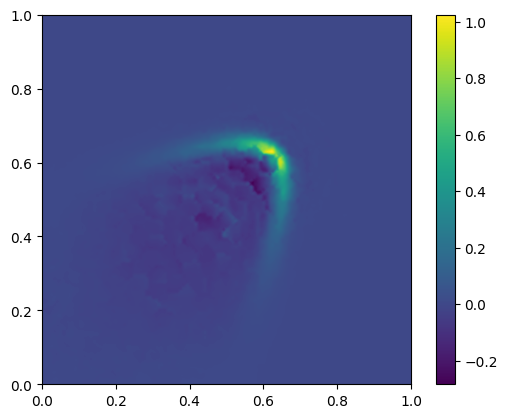

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
datas[999:1001, N:]

tensor([[2.5000e-03, 2.4000e-03, 2.2500e-03,  ..., 4.8000e-30, 4.8000e-30,
         6.9900e-30]], device='cuda:0')

In [ ]:
approximates[0]

tensor([0.0051, 0.0048, 0.0044,  ..., 0.0003, 0.0003, 0.0003], device='cuda:0',
       grad_fn=<SelectBackward0>)

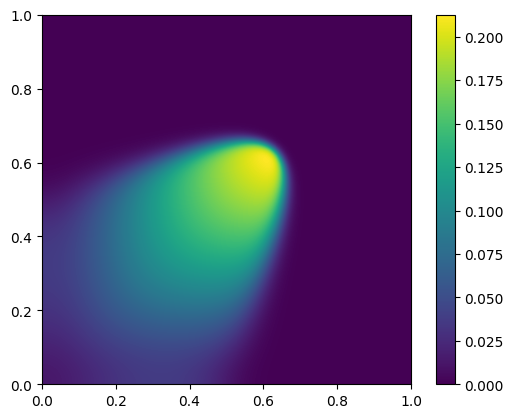

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, :N].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

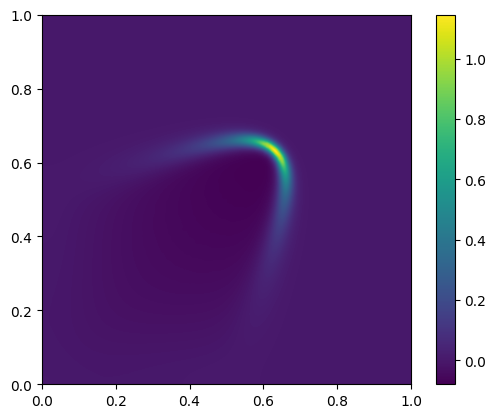

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
err = abs(datas[999] - approximates[0])

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

RuntimeError: The size of tensor a (29282) must match the size of tensor b (14641) at non-singleton dimension 0

In [ ]:
encoded = ed.nrbs.encode(datas[999].to(device))

In [ ]:
encoded.shape

torch.Size([20])

In [ ]:
bandwidths = torch.bmm(
            encoded.repeat(n, 1, 1), ed.nrbs.bandwidth_layers
        ).permute(1, 0, 2)
bandwidths = bandwidths.detach().cpu()
bandwidths = torch.sigmoid(bandwidths)

TypeError: bmm(): argument 'mat2' (position 2) must be Tensor, not Linear

In [ ]:
basis_id = 0
bandwidths_loc = torch.zeros((N,))
for i in range(m):
    bandwidths_loc[np.where(clustering.labels_ == i)[0]] = bandwidths[:,basis_id,:][0][i]

In [ ]:
bandwidths[:,basis_id,:][0][i]

tensor(0.4977)

In [ ]:
bandwidths_loc.shape

torch.Size([14641])

In [ ]:
clustering.labels_.shape

(14641,)

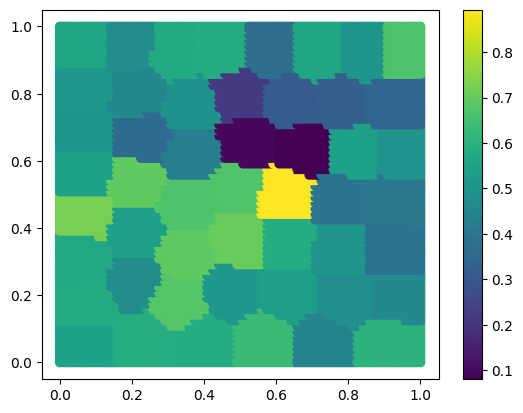

In [ ]:
plt.scatter(coords_x, coords_y,c=bandwidths_loc)
plt.colorbar()

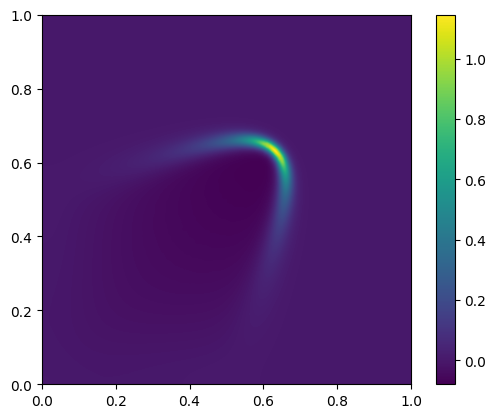

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
max(bandwidths_loc)

tensor(0.8932)

In [ ]:
min(bandwidths_loc)

tensor(0.0802)

In [ ]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()